# Predicción de Vacunación con LightGBM y Optuna

## Introducción

En este notebook, implementaremos un modelo basado en LightGBM para predecir la probabilidad de vacunación contra H1N1 y vacunas estacionales. Usaremos Optuna para la optimización de hiperparámetros y realizaremos un análisis detallado de las métricas del modelo.

In [68]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import optuna
from sklearn.model_selection import train_test_split, StratifiedKFold
from lightgbm import LGBMClassifier
import optuna.visualization as vis

## 1. Carga de datos

Comenzamos cargando el dataset preprocesado (preprocessed_training_simple_dataset.csv) que contiene las características, y el archivo de etiquetas (training_set_labels.csv) que incluye las variables objetivo: h1n1_vaccine y seasonal_vaccine.

In [70]:
# Cargar datos
X = pd.read_csv("../../Data/preprocessed_training_with_missing_handling.csv", index_col="respondent_id")
y = pd.read_csv("../../Data/training_set_labels.csv", index_col="respondent_id", usecols=["respondent_id", "h1n1_vaccine", "seasonal_vaccine"])

# Reemplazar caracteres problemáticos en los nombres de las columnas para LGBM
X.columns = X.columns.str.replace(r'[^\w]', '_', regex=True)

## 2. Dividir los datos en conjuntos de entrenamiento y prueba

Separaremos el dataset en entrenamiento (80%) y prueba (20%) para evaluar el rendimiento del modelo.

In [71]:
# Dividir datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## 3. Optimización de Hiperparámetros con Optuna

Usamos Optuna para encontrar los mejores hiperparámetros para nuestro modelo LightGBM.

### Función Objetivo

La función objetivo define el espacio de búsqueda de hiperparámetros y entrena el modelo en validación cruzada.

In [96]:
X_train = pd.read_csv("../../Data/preprocessed_X_train.csv", index_col="respondent_id")
X_test = pd.read_csv("../../Data/preprocessed_X_test.csv", index_col="respondent_id")
y_train = pd.read_csv("../../Data/preprocessed_y_train.csv", index_col="respondent_id")
y_test = pd.read_csv("../../Data/preprocessed_y_test.csv", index_col="respondent_id")

X_train.columns = X_train.columns.str.replace(r'[^\w]', '_', regex=True)
X_test.columns = X_test.columns.str.replace(r'[^\w]', '_', regex=True)

In [99]:
def objective(trial, X, y):
    # Espacio de búsqueda de hiperparámetros ajustado
    param_grid = {
        "n_estimators"    : trial.suggest_int('n_estimators', 100, 500, step=25),
        "max_depth"       : trial.suggest_int("max_depth", 3, 15),
        "reg_alpha"       : trial.suggest_float("reg_alpha", 0.01, 10, step=0.0001),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1, step=0.0001),
        "learning_rate"   : trial.suggest_float("learning_rate", 0.01, 0.15, step=0.0001),
        "reg_lambda"      : trial.suggest_float("reg_lambda", 1, 100, step=0.0001),
        "subsample"       : trial.suggest_float("subsample", 0.05, 1, step=0.0001),
        "class_weight": trial.suggest_categorical("class_weight", ["balanced"]),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0.35, 0.5, step=0.001),  
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 4),
    }

    # Clasificador LGBM
    model = LGBMClassifier(**param_grid, boosting_type='gbdt', metric='auc', objective='binary', n_jobs=-1, verbose=-1)
    
    skf = StratifiedKFold(n_splits=5, shuffle=True)
    scores = []

    for train_idx, val_idx in skf.split(X, y):
        X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
        y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

        model.fit(X_train_fold, y_train_fold)
        y_pred = model.predict_proba(X_val_fold)[:, 1]  # Probabilidades para la clase positiva
        score = roc_auc_score(y_val_fold, y_pred)
        scores.append(score)

    return np.mean(scores)

## 4. Optimización para h1n1_vaccine

Realizamos la optimización para el objetivo h1n1_vaccine con 100 pruebas de Optuna.

In [100]:
# Optuna para h1n1_vaccine
sampler = optuna.samplers.TPESampler(n_startup_trials=10, seed=42)
study_h1n1 = optuna.create_study(direction='maximize', sampler=sampler)

# Función lambda para la etiqueta h1n1_vaccine
func_h1n1 = lambda trial: objective(trial, X_train, y_train['h1n1_vaccine'])

# Optimizar
optuna.logging.set_verbosity(optuna.logging.WARNING)
study_h1n1.optimize(func_h1n1, n_trials=50, show_progress_bar=True)

Best trial: 11. Best value: 0.869723: 100%|██████████| 50/50 [03:49<00:00,  4.59s/it]


Visualización de Importancia de Parámetros

In [101]:
optuna.importance.get_param_importances(study_h1n1)

{'colsample_bytree': 0.558039436173177,
 'learning_rate': 0.18485555792992356,
 'n_estimators': 0.09250204715401206,
 'reg_alpha': 0.06648447654243488,
 'max_depth': 0.06306543906876208,
 'reg_lambda': 0.022850121650493733,
 'min_gain_to_split': 0.005725236934131688,
 'subsample': 0.003857563167160647,
 'min_data_in_leaf': 0.0026201213799042877,
 'class_weight': 0.0}

In [102]:
vis.plot_param_importances(study_h1n1)

In [103]:
# Mejores hiperparámetros para h1n1_vaccine
best_params_h1n1 = study_h1n1.best_params
print("Mejores hiperparámetros para h1n1_vaccine:", best_params_h1n1)

Mejores hiperparámetros para h1n1_vaccine: {'n_estimators': 450, 'max_depth': 9, 'reg_alpha': 0.063, 'colsample_bytree': 0.3962, 'learning_rate': 0.0708, 'reg_lambda': 73.2784, 'subsample': 0.7208000000000001, 'class_weight': 'balanced', 'min_gain_to_split': 0.44099999999999995, 'min_data_in_leaf': 2}


Entrenamos el modelo con los mejores hiperparámetros obtenidos

In [104]:
model_h1n1 = LGBMClassifier(**best_params_h1n1, boosting_type='gbdt', metric='auc', objective='binary', n_jobs=-1)
pipeline_h1n1 = Pipeline([
    ('classifier', LGBMClassifier(n_estimators      = best_params_h1n1['n_estimators'],
                                  learning_rate     = round(best_params_h1n1['learning_rate'],4),
                                  max_depth         = best_params_h1n1['max_depth'],
                                  reg_alpha         = round(best_params_h1n1['reg_alpha'],4),
                                  reg_lambda        = round(best_params_h1n1['reg_lambda'],4),
                                  subsample         = round(best_params_h1n1['subsample'],4),
                                  colsample_bytree  = round(best_params_h1n1['colsample_bytree'],4),
                                  class_weight      = best_params_h1n1['class_weight'],
                                  min_gain_to_slip  = best_params_h1n1['min_gain_to_split'],
                                  min_data_in_leaf  = best_params_h1n1['min_data_in_leaf'],
                                  boosting_type='gbdt', metric='auc', objective='binary', n_jobs=-1))
])
pipeline_h1n1.fit(X_train, y_train['h1n1_vaccine'])

Pipeline(steps=[('classifier',
                 LGBMClassifier(class_weight='balanced',
                                colsample_bytree=0.3962, learning_rate=0.0708,
                                max_depth=9, metric='auc', min_data_in_leaf=2,
                                min_gain_to_slip=0.44099999999999995,
                                n_estimators=450, n_jobs=-1, objective='binary',
                                reg_alpha=0.063, reg_lambda=73.2784,
                                subsample=0.7208))])

## 5. Evaluación del Modelo para h1n1_vaccine

**Métricas de Rendimiento:**

- ROC AUC: Calculamos el área bajo la curva ROC.
- Curva ROC: Representación gráfica de los valores de TPR y FPR.
- Matriz de Confusión: Analizamos el desempeño del modelo en clases.

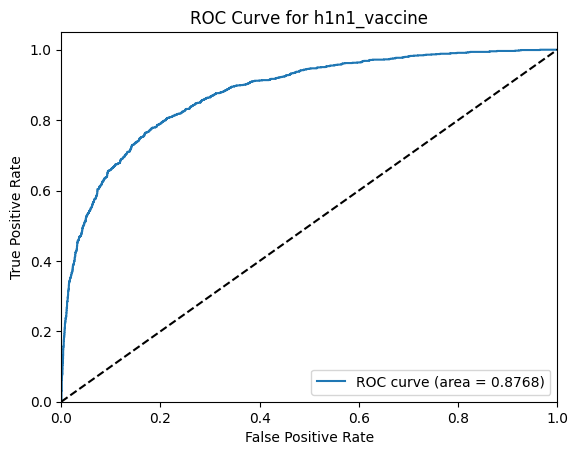

In [105]:
h1n1_predictions = pipeline_h1n1.predict(X_test)
h1n1_probabilities = pipeline_h1n1.predict_proba(X_test)[:, 1]

# Calculamos la curva ROC y el valor ROC AUC para h1n1_vaccine
fpr, tpr, thresholds = roc_curve(y_test['h1n1_vaccine'], h1n1_probabilities)
roc_auc_h1n1 = roc_auc_score(y_test['h1n1_vaccine'], h1n1_probabilities)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc_h1n1)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for h1n1_vaccine')
plt.legend(loc="lower right")
plt.show()

In [79]:
print("h1n1_vaccine Classification Report:")
print(classification_report(y_test['h1n1_vaccine'], h1n1_predictions))

h1n1_vaccine Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.82      0.87      4207
           1       0.54      0.77      0.63      1135

    accuracy                           0.81      5342
   macro avg       0.74      0.80      0.75      5342
weighted avg       0.85      0.81      0.82      5342



In [80]:
# Matriz de confusión
cm_h1n1 = confusion_matrix(y_test['h1n1_vaccine'], h1n1_predictions)
print(cm_h1n1)

[[3469  738]
 [ 265  870]]


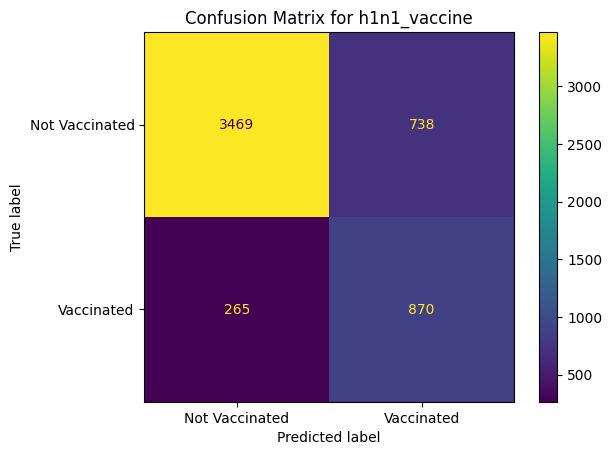

In [81]:
# Vemos la matriz de confusión
disp_h1n1 = ConfusionMatrixDisplay(confusion_matrix=cm_h1n1, display_labels=['Not Vaccinated', 'Vaccinated'])
disp_h1n1.plot()
plt.title('Confusion Matrix for h1n1_vaccine')
plt.show()

## 6. Optimización para seasonal_vaccine

Repetimos el mismo proceso de optimización y evaluación para el objetivo seasonal_vaccine.

In [106]:
def objective_seasonal(trial, X, y):
    # Espacio de búsqueda de hiperparámetros
    param_grid = {
        "n_estimators"    : trial.suggest_int('n_estimators', 100, 500, step=25),
        "max_depth"       : trial.suggest_int("max_depth", 3, 15),
        "reg_alpha"       : trial.suggest_float("reg_alpha", 0.01, 10, step=0.0001),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1, step=0.0001),
        "learning_rate"   : trial.suggest_float("learning_rate", 0.01, 0.15, step=0.0001),
        "reg_lambda"      : trial.suggest_float("reg_lambda", 1, 100, step=0.0001),
        "subsample"       : trial.suggest_float("subsample", 0.05, 1, step=0.0001),
        "class_weight": trial.suggest_categorical("class_weight", ["balanced"]),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0.35, 0.5, step=0.001),  
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 4),
    }

    # Clasficador LGBM
    model = LGBMClassifier(**param_grid, boosting_type='gbdt', metric='auc', objective='binary', n_jobs=-1, verbose=-1)
    
    skf = StratifiedKFold(n_splits=5, shuffle=True)
    scores = []

    for train_idx, val_idx in skf.split(X, y):
        X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
        y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

        model.fit(X_train_fold, y_train_fold)
        y_pred = model.predict_proba(X_val_fold)[:, 1]  # Probabilidades para la clase positiva
        score = roc_auc_score(y_val_fold, y_pred)
        scores.append(score)

    return np.mean(scores)

In [107]:
study_seasonal = optuna.create_study(direction='maximize', sampler=sampler)
func = lambda trial: objective_seasonal(trial, X_train, y_train['seasonal_vaccine'])
optuna.logging.set_verbosity(optuna.logging.WARNING)
study_seasonal.optimize(func, n_trials=50, n_jobs=-1, show_progress_bar=True)

Best trial: 38. Best value: 0.864359: 100%|██████████| 50/50 [01:37<00:00,  1.94s/it]


In [108]:
optuna.importance.get_param_importances(study_seasonal)

{'learning_rate': 0.663452516319706,
 'colsample_bytree': 0.25645972849683585,
 'reg_alpha': 0.028621687160786405,
 'max_depth': 0.015179850697684356,
 'n_estimators': 0.014045103366361517,
 'min_gain_to_split': 0.011051504250575802,
 'subsample': 0.006037879673938081,
 'reg_lambda': 0.004096693275567305,
 'min_data_in_leaf': 0.0010550367585446065,
 'class_weight': 0.0}

In [109]:
vis.plot_param_importances(study_seasonal)

In [110]:
# Mejores hiperparámetros para seasonal_vaccine
best_params_seasonal = study_seasonal.best_params
print("Best Params for seasonal_vaccine:", best_params_seasonal)

Best Params for seasonal_vaccine: {'n_estimators': 250, 'max_depth': 14, 'reg_alpha': 0.0851, 'colsample_bytree': 0.4081, 'learning_rate': 0.0814, 'reg_lambda': 68.92750000000001, 'subsample': 0.6479, 'class_weight': 'balanced', 'min_gain_to_split': 0.423, 'min_data_in_leaf': 1}


Entrenamos el modelo con los mejores hiperparámetros obtenidos.

In [111]:
model_seasonal = LGBMClassifier(**best_params_seasonal, boosting_type='gbdt', metric='auc', objective='binary', n_jobs=-1)
pipeline_seasonal = Pipeline([
    ('classifier', LGBMClassifier(n_estimators      = best_params_seasonal['n_estimators'],
                                  learning_rate     = round(best_params_seasonal['learning_rate'],4),
                                  max_depth         = best_params_seasonal['max_depth'],
                                  reg_alpha         = round(best_params_seasonal['reg_alpha'],4),
                                  reg_lambda        = round(best_params_seasonal['reg_lambda'],4),
                                  subsample         = round(best_params_seasonal['subsample'],4),
                                  colsample_bytree  = round(best_params_seasonal['colsample_bytree'],4),
                                  class_weight      = best_params_seasonal['class_weight'],
                                  min_gain_to_split = best_params_seasonal['min_gain_to_split'],
                                  min_data_in_leaf  = best_params_seasonal['min_data_in_leaf'],
                                  boosting_type='gbdt', metric='auc', objective='binary', n_jobs=-1))
])
pipeline_seasonal.fit(X_train, y_train['seasonal_vaccine'])

Pipeline(steps=[('classifier',
                 LGBMClassifier(class_weight='balanced',
                                colsample_bytree=0.4081, learning_rate=0.0814,
                                max_depth=14, metric='auc', min_data_in_leaf=1,
                                min_gain_to_split=0.423, n_estimators=250,
                                n_jobs=-1, objective='binary', reg_alpha=0.0851,
                                reg_lambda=68.9275, subsample=0.6479))])

### Evaluación del modelo

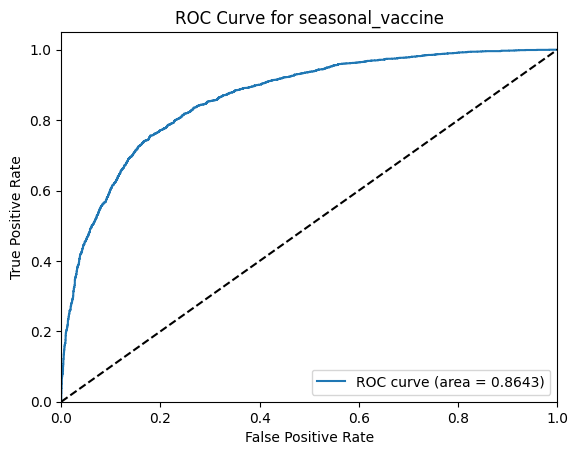

In [112]:
seasonal_predictions = pipeline_seasonal.predict(X_test)
seasonal_probabilities = pipeline_seasonal.predict_proba(X_test)[:, 1]

# Calculamos la curva ROC y el valor ROC AUC para seasonal
fpr, tpr, thresholds = roc_curve(y_test['seasonal_vaccine'], seasonal_probabilities)
roc_auc_seasonal = roc_auc_score(y_test['seasonal_vaccine'], seasonal_probabilities)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc_seasonal)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for seasonal_vaccine')
plt.legend(loc="lower right")
plt.show()

In [113]:
print("seasonal_vaccine Classification Report:")
print(classification_report(y_test['seasonal_vaccine'], seasonal_predictions))

seasonal_vaccine Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.79      0.80      2854
           1       0.76      0.78      0.77      2488

    accuracy                           0.78      5342
   macro avg       0.78      0.78      0.78      5342
weighted avg       0.79      0.78      0.79      5342



In [114]:
# Matriz de confusión
cm_seasonal = confusion_matrix(y_test['seasonal_vaccine'], seasonal_predictions)
print(cm_seasonal)

[[2244  610]
 [ 539 1949]]


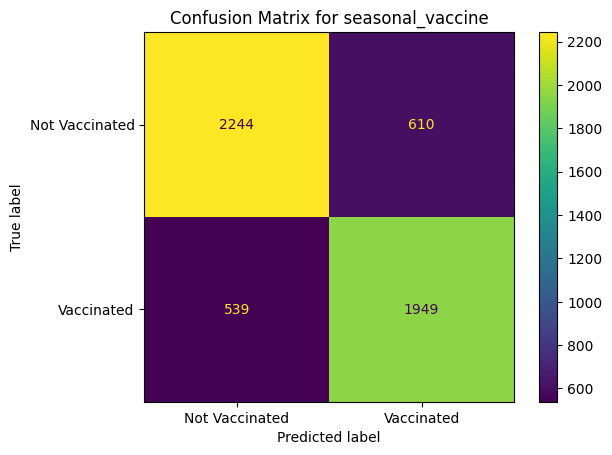

In [115]:
# Representamos la matriz de confusión
disp_seasonal = ConfusionMatrixDisplay(confusion_matrix=cm_seasonal, display_labels=['Not Vaccinated', 'Vaccinated'])
disp_seasonal.plot()
plt.title('Confusion Matrix for seasonal_vaccine')
plt.show()

Para nuestra competición nos interesa el área bajo la curva ROC como métrica de evaluación por lo que vamos a calcular la media de esta métrica obtenida entre los modelos.

In [116]:
# Calcular la media del valor ROC AUC
average_roc_auc = (roc_auc_h1n1 + roc_auc_seasonal) / 2
print("Average ROC AUC Score:", average_roc_auc)

Average ROC AUC Score: 0.8705860025978416


## 7. Generación del Archivo de Envío

Finalmente, usamos los modelos optimizados para predecir las probabilidades en el dataset de prueba y generamos el archivo submission.csv.

In [117]:
test_X = pd.read_csv("../../Data/preprocessed_test_set_features.csv", index_col="respondent_id")
test_probas_h1n1 = pipeline_h1n1.predict_proba(test_X)
test_probas_seasonal = pipeline_seasonal.predict_proba(test_X)

In [118]:
submission_df = pd.read_csv("../../Data/submission_format.csv", index_col="respondent_id")
np.testing.assert_array_equal(test_X.index.values, submission_df.index.values)

submission_df["h1n1_vaccine"] = test_probas_h1n1[:, 1]
submission_df["seasonal_vaccine"] = test_probas_seasonal[:, 1]
submission_df.head()

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.303481,0.352166
26708,0.106646,0.042917
26709,0.518609,0.763335
26710,0.885170,0.903184
26711,0.517837,0.445720


In [119]:
submission_df.to_csv('Submissions/LGBM_optuna_with_missing_handling_50trials.csv', index=True)